In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import xgboost as xgb
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,10)
import seaborn as sns
from ipynb.fs.full.Performance_Utilities import calculate_optimal_threshold, print_metrics
from utils.create_features_utils import *
from sklearn.base import clone
import os

In [2]:
full_file = "data/all_matches_with_feature.csv"
raw_tennis_file = "data/mens/combined_raw_data.csv"
round_16_file = "data/wimbledon_2019.csv"

In [3]:
full_tennis = pd.read_csv(full_file) # All results from all years
round_16 = pd.read_csv(round_16_file) # Round of 16 and on from Wimbledon 2019
raw_tennis = pd.read_csv(raw_tennis_file) # Raw tennis file

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
features_list = [
 'diff_rank',
 'diff_match_win_percent',
 'diff_games_win_percent',
 'diff_5_set_match_win_percent',
 'diff_close_sets_percent',
 'diff_match_win_percent_grass',
 'diff_games_win_percent_grass',
 'diff_5_set_match_win_percent_grass',
 'diff_close_sets_percent_grass',
 'diff_match_win_percent_52',
 'diff_games_win_percent_52',
 'diff_5_set_match_win_percent_52',
 'diff_close_sets_percent_52',
 'diff_match_win_percent_grass_60',
 'diff_games_win_percent_grass_60',
 'diff_5_set_match_win_percent_grass_60',
 'diff_close_sets_percent_grass_60',
 'diff_match_win_percent_hh',
 'diff_games_win_percent_hh',
 'diff_match_win_percent_grass_hh',
 'diff_games_win_percent_grass_hh']

In [5]:
full_tennis = full_tennis.dropna()

full_tennis['diff_rank'] = full_tennis['player_0_rank'] - full_tennis['player_1_rank']

In [6]:
# Train-test split
y = full_tennis.outcome
X = full_tennis[features_list]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, shuffle=True, test_size=0.20)

In [7]:
# Final to predict on
round_16['Date'] = '2019/07/07'
round_16['Surface'] = 'Grass'
round_16['diff_rank'] = round_16['player_0_rank'] - round_16['player_1_rank']

wimby_2019 = create_features(round_16, raw_tennis) # Round 16 and on Wimby 2019
X_wimby_2019 = wimby_2019[features_list]

Creating Player Career Stats All Surface
Creating Player Career Stats on Grass/Clay/Hard
Creating Player Career Stats All Surface Last 52 Weeks
Creating Player Career Stats on Grass/Clay/Hard Last 60 Weeks
Creating Player Head to Head Career Stats All Surface
Creating Player Head to Head Career Stats On Grass
Creating Difference Variables


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1143: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https

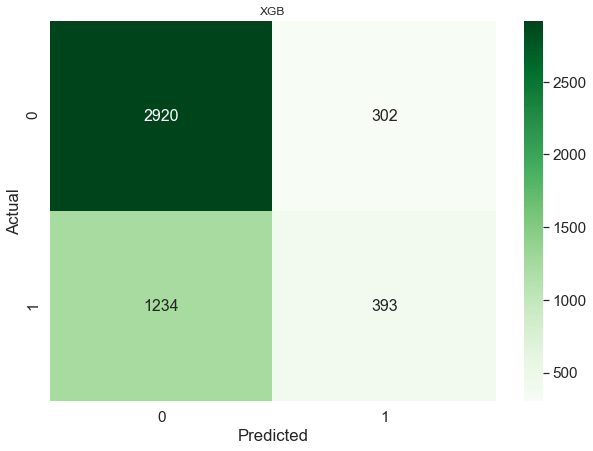

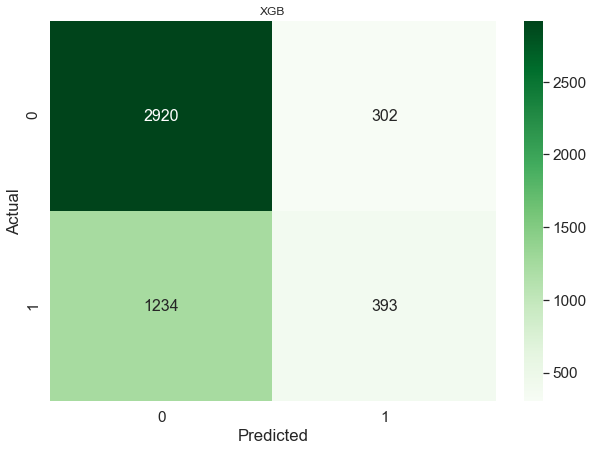

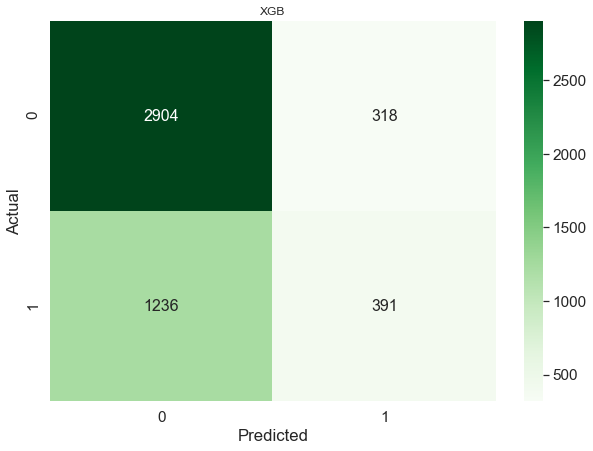

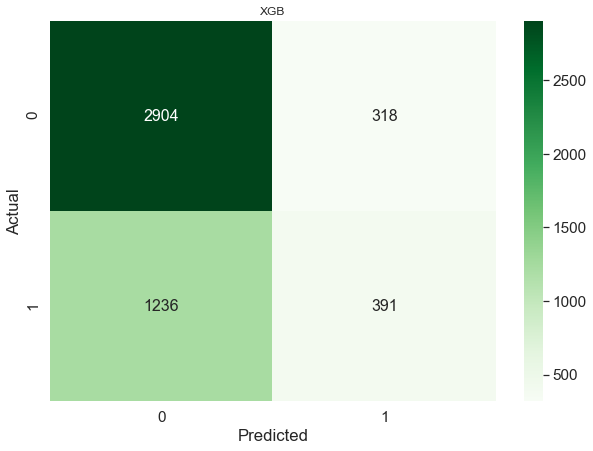

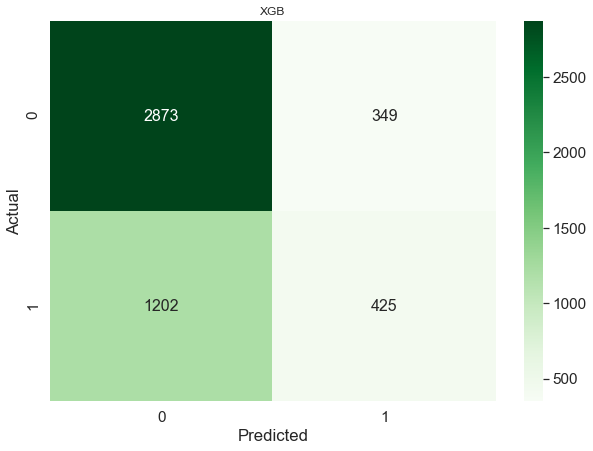

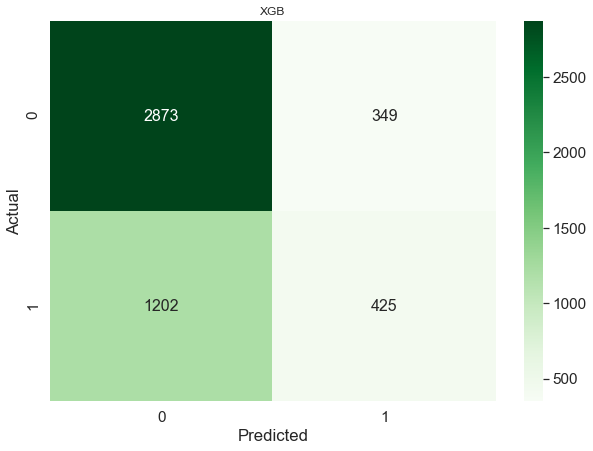

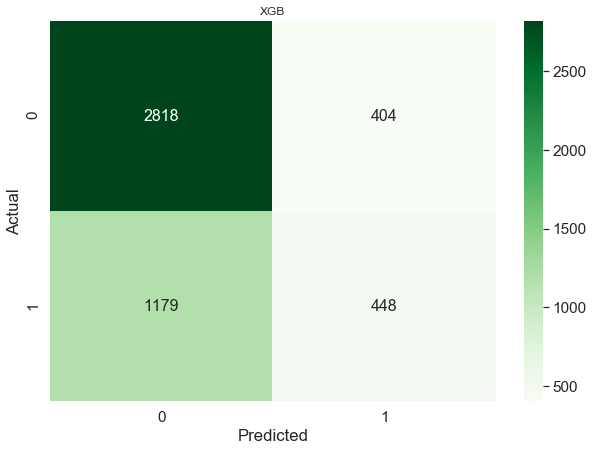

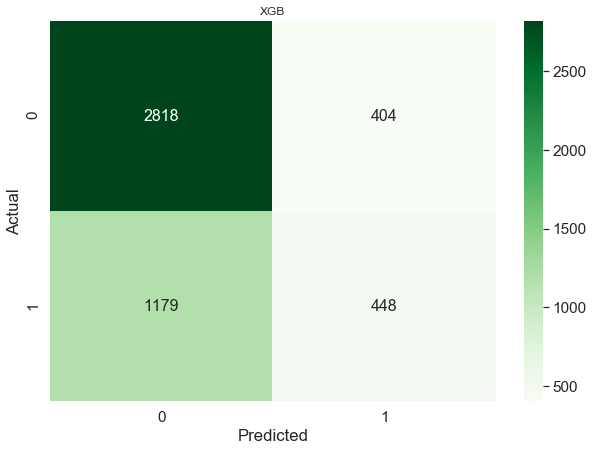

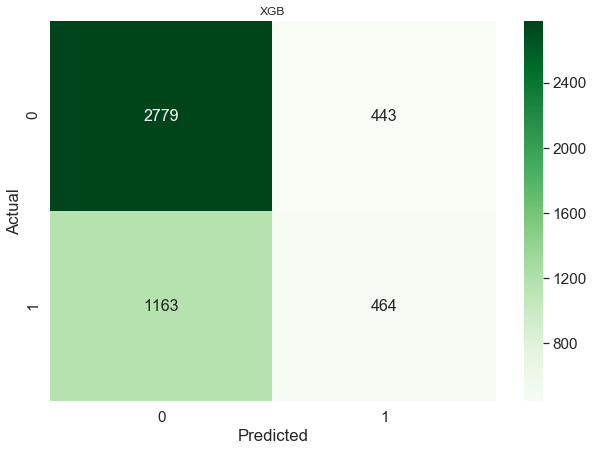

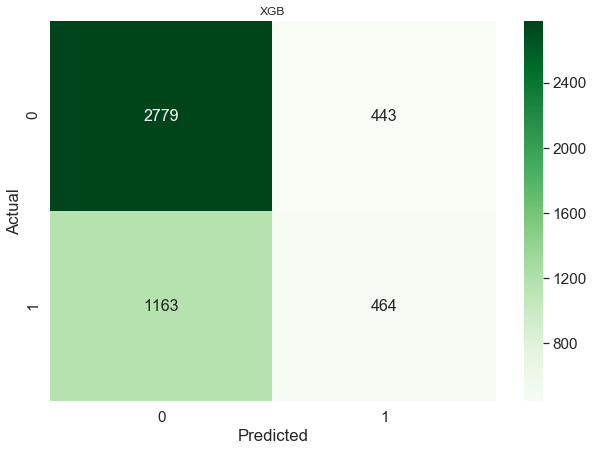

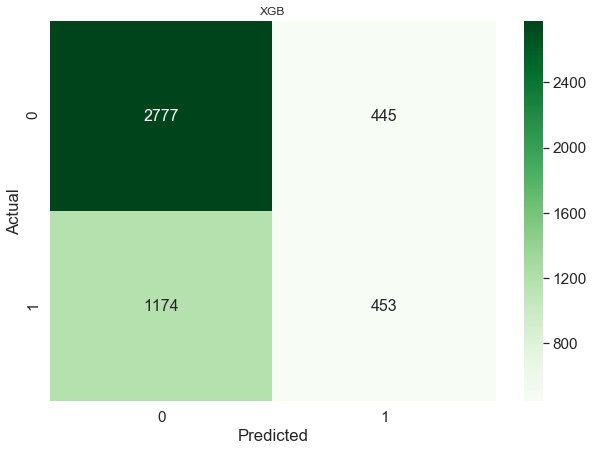

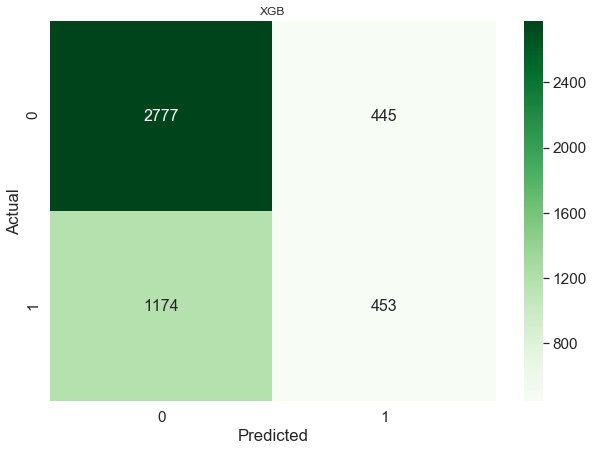

In [8]:
# XGBoost
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
max_depth = [3, 5, 7, 10, 12, 14]
auc_ls = []
f1_ls = []

for i in max_depth:
    xgb_model = xgb.XGBClassifier(max_depth = i, nthread=-1)
    xgb_model.fit(X_train, y_train)
    auc = print_metrics(X_test, y_test, xgb_model, "XGB")[2]
    f1 = print_metrics(X_test, y_test, xgb_model, "XGB")[3]
    auc_ls.append(auc)
    f1_ls.append(f1)

In [9]:
print(auc_ls)
print(f1_ls)

[0.686, 0.686, 0.682, 0.67, 0.67, 0.664]
[0.339, 0.335, 0.354, 0.361, 0.366, 0.359]


[3.2 3.2 2.8 1.6 1.6 1. ]
[1.04 1.   1.19 1.26 1.31 1.24]


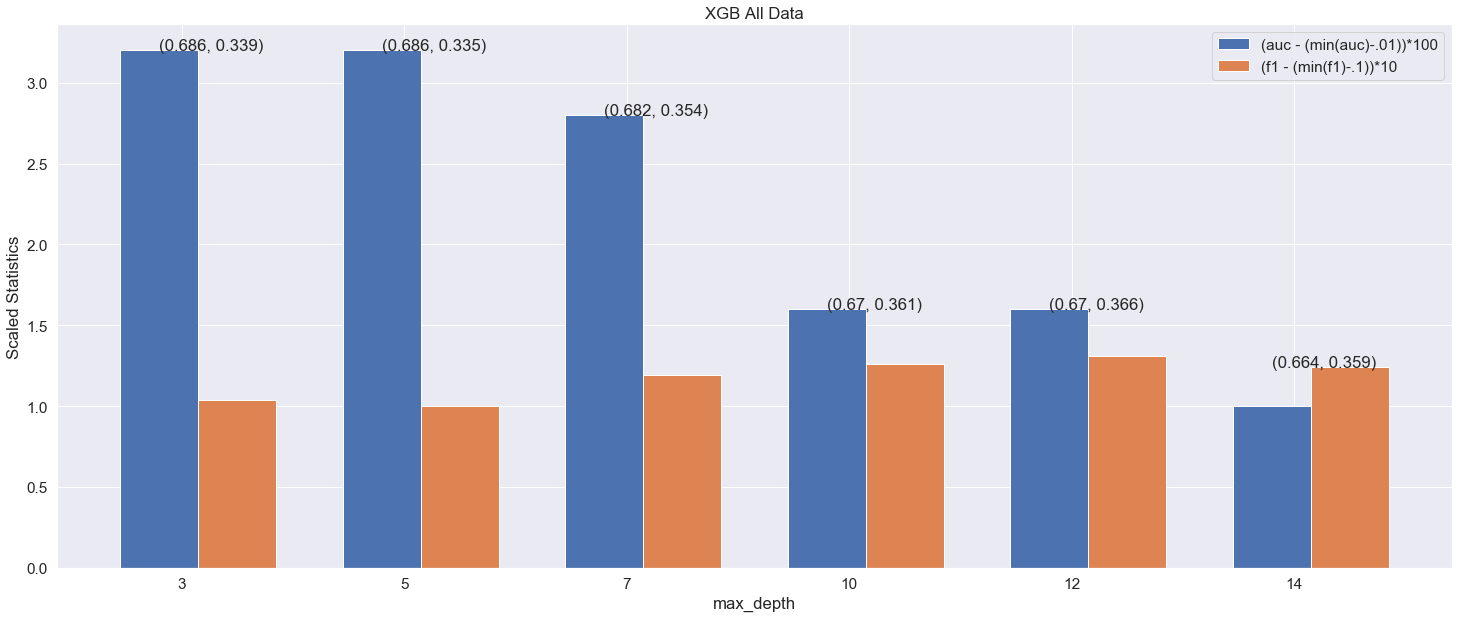

In [14]:
# Scale for plotting
scale_auc_ls = (auc_ls - (min(auc_ls)-.01))*100
print(scale_auc_ls)
scale_f1_ls = (f1_ls - (min(f1_ls)-.1))*10
print(scale_f1_ls)

# Plot
n_combos = len(max_depth)
index = np.arange(n_combos)
axes = plt.gca()
bar_width = .35

aucs = plt.bar(index, scale_auc_ls, bar_width, label = "(auc - (min(auc)-.01))*100")
f1s = plt.bar(index+bar_width, scale_f1_ls, bar_width, label = "(f1 - (min(f1)-.1))*10")

plt.xticks(index+.1, max_depth)
for i, v in enumerate(scale_auc_ls):
    plt.text(i, max(scale_auc_ls[i], scale_f1_ls[i]), str((auc_ls[i], f1_ls[i])))

plt.xlabel("max_depth")
plt.ylabel("Scaled Statistics")
plt.title("XGB All Data")
plt.legend()

In [11]:
xgb_model = xgb.XGBClassifier(max_depth = 7, nthread=-1)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
xgb_model.predict_proba(X_wimby_2019)

array([[0.9729489 , 0.02705109],
       [0.41025615, 0.58974385],
       [0.74923754, 0.25076243],
       [0.8458141 , 0.15418586],
       [0.76341206, 0.23658794],
       [0.9002976 , 0.09970243],
       [0.7434696 , 0.2565304 ],
       [0.7168597 , 0.28314027],
       [0.79664433, 0.20335566],
       [0.52323544, 0.4767646 ],
       [0.77567196, 0.22432801],
       [0.84271383, 0.15728615],
       [0.794604  , 0.20539601],
       [0.5238966 , 0.47610343],
       [0.54792047, 0.4520795 ],
       [0.5750394 , 0.42496058]], dtype=float32)